In [46]:
using DrWatson # a scientific project assistant package. It helps managing scientific projects, e.g., reproducibility, data analysis, etc.
@quickactivate "KerrDimer"

using HarmonicBalance; HB = HarmonicBalance # A package for solving the complete solution space of nonlinear oscillatros
using Symbolics
import HarmonicBalance.LinearResponse.plot_linear_response # The linear reponse module of HB

using Plots, Measures # Plotting tools
using Logging; Logging.disable_logging(Logging.Warn); # Gets rid of the annoying "Warning: non-negligible complex parts have been projected on the real axis" message

## Mean-field equations

In [47]:
# defining variables
@variables αᵣ₁::Real, αᵢ₁::Real, αᵣ₂::Real, αᵢ₂::Real
@variables Δ::Real, κ::Real, U::Real, F::Real, J::Real
@variables α₁::Complex{Real}, α₂::Complex{Real}

# accounting for the fact that we "divide" each complex equation in its real and imaginary part
function replace_split(f,sub_rules)
    exp = substitute(real(f),sub_rules) + 1.0im*substitute(imag(f),sub_rules)
    [real(exp), imag(exp)]
end

function get_EOM_full()
    K₁ = (-Δ + conj(α₁)*α₁ - 1.0im*κ/2)*α₁ + F*sqrt(U)
    K₂ = (-Δ + conj(α₂)*α₂ - 1.0im*κ/2)*α₂ 
    
    fψ₁ =   -1.0im*(K₁ - J*α₂) 
    fψ₂ =   -1.0im*(K₂ - J*α₁) 
    
    sub_rules = Dict((real(α₁)=>αᵣ₁), (imag(α₁)=>αᵢ₁), (real(α₂)=>αᵣ₂), (imag(α₂)=>αᵢ₂))

    variables = [αᵣ₁, αᵢ₁, αᵣ₂, αᵢ₂]
    parameters = [Δ, κ, U, F, J]
    system_f= reduce(vcat,[replace_split(f,sub_rules) for f in [fψ₁,fψ₂]])

    equation_HC = HarmonicBalance.Problem(system_f,variables,parameters);
    return equation_HC
end

MF_eqs = get_EOM_full();

In [48]:
### Hot fix required for the eom field in the harmonic equations object to not be empty. 
### Will be corrected in future versions
# declare dummy system: declare constant variables and two functions x(t) and y(t)
@variables α, ω, ω0, t, η, x(t), y(t)

# differential equations
diff_eq = DifferentialEquation([d(x,t,2) + ω0^2*x + α*x^3 + η*d(x,t)*x^2 ~ 0,
                                d(y,t,2) + ω0^2*y + α*y^3 + η*d(y,t)*y^2 ~ 0], [x,y])

# specify the harmonic ansatz for x and y: x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diff_eq, x, ω)
add_harmonic!(diff_eq, y, ω)

# implement ansatz to get harmonic equations
harmonic_eq_dummy = get_harmonic_equations(diff_eq)

MF_eqs.eom = harmonic_eq_dummy;
MF_eqs.system;

In [49]:
# parameters
κᵣ = 1. #reference value for unitless parameters
Uᵣ = 1.
#under these assumptions, Ftilde = F and J/κ = J
fixed = (κ => κᵣ, Δ => 2*κᵣ, U => Uᵣ)
varied = (F => range(0,5,200), J => range(0,2*κᵣ,200))

# results
result = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

A steady state result for 40000 parameter points

Solution branches:   9
   of which real:    7
   of which stable:  7

Classes: stable, physical, Hopf, binary_labels


### Phase diagrams

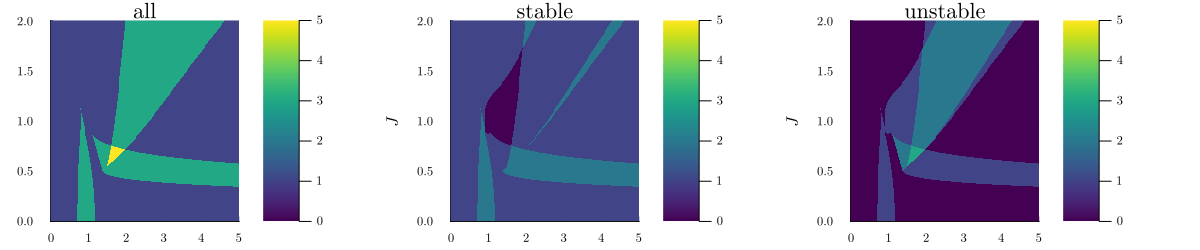

In [50]:
p1 = plot_phase_diagram(result,title="all", clim =(0,5))
p2 = plot_phase_diagram(result,class="stable",title="stable", clim =(0,5))
p3 = plot_phase_diagram(result,not_class="stable",title="unstable", clim =(0,5))

p_MF = plot([p1,p2,p3]..., layout = (1,3), size = (1200,250))

## The same with Harmonic balance
Replace RWA by harmonic balance around the driving frequency: The previous phase diagram can be recovered at a new effective detuning

In [51]:
@variables α, ω, ω0, t, γ, x(t), y(t)

eqs_beyond_RWA = [d(x,t,2) + γ*d(x,t,1) + ω0^2*x + α*x^3 - J*y ~ F*sqrt(U)*sin(ω*t),
                  d(y,t,2) + γ*d(y,t,1) + ω0^2*y + α*y^3  - J*x ~ 0]

# differential equations
diffeq_beyond_RWA = DifferentialEquation(eqs_beyond_RWA, [x,y])

# specify the harmonic ansatz for x and y: x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diffeq_beyond_RWA, x, ω)
add_harmonic!(diffeq_beyond_RWA, y, ω)

MF_eqs_beyond_RWA = get_harmonic_equations(diffeq_beyond_RWA);

In [52]:
# parameters
Uᵣ = 1.; κᵣ = 1. #reference value for unitless parameters
ωᵣ = sqrt(2*κᵣ) 
# the effective detuning parameter is (ω0^2-ω^2)/ω in the equations 
# under these assumptions, Ftilde = F and J/κ = J
fixed = ( γ=> κᵣ/(2*ωᵣ), ω=>ωᵣ , ω0 => 0. , α=>(4/3), U=>1)
varied = (F => range(0.0,5,200), J => range(0.0,2.,200))

# results
result_beyond_RWA = get_steady_states(MF_eqs_beyond_RWA, varied, fixed, show_progress=false, threading=true)

A steady state result for 40000 parameter points

Solution branches:   9
   of which real:    7
   of which stable:  6

Classes: stable, physical, Hopf, binary_labels


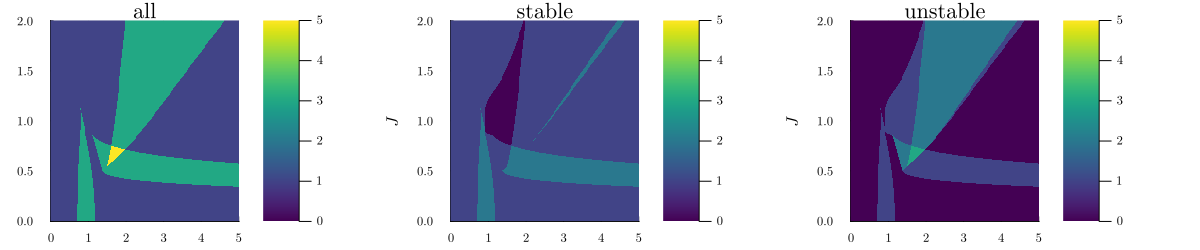

In [53]:
p1 = plot_phase_diagram(result_beyond_RWA ,title="all", clim = (0, 5))
p2 = plot_phase_diagram(result_beyond_RWA ,class="stable",title="stable", clim = (0, 5))
p3 = plot_phase_diagram(result_beyond_RWA ,not_class="stable",title="unstable", clim = (0, 5))

p_HB = p= plot([p1,p2,p3]..., layout = (1,3), size = (1200,250))

## Comparison MF eq and HB eq

In [54]:
result.problem.system.expressions

4-element Vector{HomotopyContinuation.ModelKit.Expression}:
             -J*αᵢ₂ - 0.5*κ*αᵣ₁ + (-Δ + αᵢ₁^2 + αᵣ₁^2)*αᵢ₁
 -F*sqrt(U) + J*αᵣ₂ - 0.5*κ*αᵢ₁ - (-Δ + αᵢ₁^2 + αᵣ₁^2)*αᵣ₁
             -J*αᵢ₁ - 0.5*κ*αᵣ₂ + (-Δ + αᵢ₂^2 + αᵣ₂^2)*αᵢ₂
              J*αᵣ₁ - 0.5*κ*αᵢ₂ - (-Δ + αᵢ₂^2 + αᵣ₂^2)*αᵣ₂

In [55]:
result_beyond_RWA.problem.system.expressions

4-element Vector{HomotopyContinuation.ModelKit.Expression}:
             -J*u2 - u1*ω^2 + u1*ω0^2 + (3/4)*u1^3*α + (3/4)*u1*v1^2*α + v1*γ*ω
 -F*sqrt(U) - J*v2 - v1*ω^2 + v1*ω0^2 + (3/4)*v1^3*α - u1*γ*ω + (3/4)*u1^2*v1*α
             -J*u1 - u2*ω^2 + u2*ω0^2 + (3/4)*u2^3*α + (3/4)*u2*v2^2*α + v2*γ*ω
             -J*v1 - v2*ω^2 + v2*ω0^2 + (3/4)*v2^3*α - u2*γ*ω + (3/4)*u2^2*v2*α

***Observation:*** Harmonic Balance equations and regular RWA equations differ in the sign of J. Probably is just the fact the quadratures are rotated in both cases

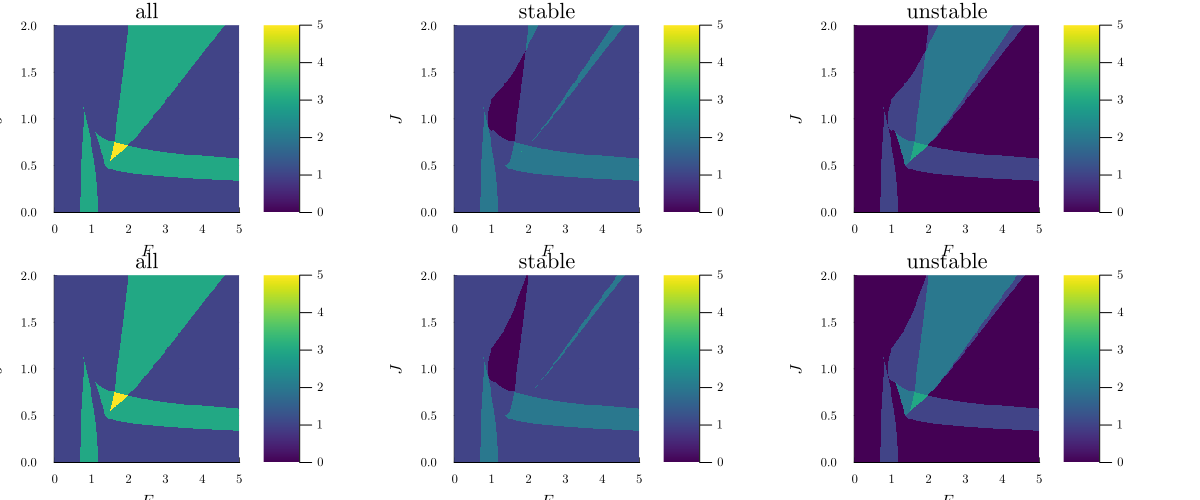

In [56]:
plot(p_MF,p_HB, layout = (2,1), size = (1200,500))